# Exercise 3 - Grasp classification using EMG signals to control a robotic hand prosthesis

In this exercise you will process EMG signals in order to decode motor intentions of the user. 

We recorded an EMG dataset that consists of a user performing different single finger and multi-finger grasps. The subject was asked to follow a virtual hand and perform the same movements to synchronize EMG and finger movements.

In the dataset available in the folder data_csv there are two csv files (EMG signals and finger positions). Finger values are 0 when a finger is opened, 1 at rest position and 2 when it is closed. We recorded 6 EMG channels at 2kHz and finger states at 60Hz.

Finger states are saved as a matrix where rows correspond to time and columns correspond to one joint (Thump opposition, Thumb, Index, Middle, Ring, Pinky). See the following image:

<img src="figures/hand_model.png" alt="Drawing" style="width: 400px;"/>

The sequence of movements is made of the following movements held for 5 seconds with a rest position of 3 seconds in between everytime: pinky flexion, ulnar flexion, middle flexion, index flexion, thumb opposition, ulnar grasp, tri-digital grasp, pincer grasp, thumb up, lateral (key) grasp, power grasp, open (note that there is no rest position between thumb up and lateral grasp).

You can see forearm muscle anatomy and function following these two links:

- https://teachmeanatomy.info/upper-limb/muscles/posterior-forearm/
- https://teachmeanatomy.info/upper-limb/muscles/anterior-forearm/

This jupyter notebook will:
- load the .csv files (EMG + Targets)
- Plot the raw data for visual inspection
- Synchronize EMG and Targets since they are recorded as two separate streams of data (2000kHz for the EMG and 60Hz for the Targets)

The aim of this exercise is to design and explore different machine learning models capable of decoding user intentions to control a robotic prosthetic hand. You will have to assess performance on unseen data to quantify the accuracy expected in a real experiment.

For the model to work in a real world scenario, the model should be fast enough to be able to decode motor intention with a small amount of data (200ms of signal is a standard value). We will use a sliding window to "cut" the data in samples that will be used to make the classification. The windows are overlapped to increase the amount of samples to train the model (see https://doi.org/10.3390/s19204596 chapter 3.2). 

However, the signal itself is usually too complex to train a machine learning model. A standard approach to train a classifier is to extract meaninful and discriminative features from the signal and use it to train the model (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307).

You can choose the model type and classification type (see https://scikit-learn.org/stable/modules/multiclass.html). You are free to choose the classification type (multi-class, multi-output,...) depending on how you will prepare the targets.

Therefore, you will have to:
- Divide the whole dataset into the three following sets: Training, Validation and Testing set.
- Extract sliding windows of 200ms from the EMG signal with an overlap of 50ms and prepare the Targets as the grasp type at the end of the time window.
- Adapt targets for grasp classification
- Extract meaningful information from raw EMG data (Feature extraction)
- Create and compare different machine learning models to decode user intention
- Evaluate performance of the final model you chose
- Plot predictions made by your model

The following figure summurize the different steps required to obtain an real-time EMG decoder:
!['title'](figures/figure_1.png)


## NOTE
### There are questions all along the notebook. You have to answer at the end of the notebook for clarity. 
### Explain the choice you made also at the end of the notebook

### Few imports

make sure you installed the following libraries in your python environment (pip install *XXX*): pandas, numpy, matplotlib, sklearn

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler

from functions.align import align

In [2]:
# Additional imports

from scipy import signal
from statsmodels.tsa.ar_model import AutoReg 
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from matplotlib.colors import ListedColormap

### Some parameters

In [3]:
window_length = 0.2 #200 ms
sliding_step = 0.05 #50 ms
sampling_frequency_EMG = 2000 #Hz   
sampling_frequency_Targets = 60 #Hz   

### First Load the csv files

In [4]:
EMG_file_name='../data_csv/EMG.csv'
target_file_name='../data_csv/Kinematics.csv'

#load csv
EMG = pd.read_csv(EMG_file_name,index_col='index')
Targets = pd.read_csv(target_file_name,index_col='index')
Targets = (Targets*2).astype(int)

### Data inspection

In [5]:
EMG

,Labjack_channel1,Labjack_channel2,Labjack_channel3,Labjack_channel4,Labjack_channel5,Labjack_channel6
index,,,,,,
0.00000,0.035438,0.025026,0.016822,0.021555,0.019977,0.006725
0.00050,0.035123,0.026288,0.016506,0.019662,0.021555,0.005463
0.00100,0.035438,0.026603,0.018084,0.019346,0.021870,0.005463
0.00150,0.033230,0.025972,0.018715,0.020924,0.020293,0.004832
0.00200,0.033545,0.029443,0.018084,0.023133,0.020608,0.005778
...,...,...,...,...,...,...
565.80051,0.047113,0.043327,0.017453,0.020924,0.014298,0.028497
565.80101,0.050899,0.046798,0.012720,0.025657,0.016822,0.013035
565.80151,0.058788,0.050899,0.010196,0.025341,0.020293,0.001676


In [6]:
Targets

,Right_Hand_channel1,Right_Hand_channel2,Right_Hand_channel3,Right_Hand_channel4,Right_Hand_channel5,Right_Hand_channel6
index,,,,,,
5.39584,1,1,1,1,1,1
5.41117,1,1,1,1,1,1
5.42762,1,1,1,1,1,1
5.44352,1,1,1,1,1,1
5.45937,1,1,1,1,1,1
...,...,...,...,...,...,...
563.61095,0,0,0,0,0,0
563.62769,0,0,0,0,0,0
563.64352,0,0,0,0,0,0


### Plot raw data

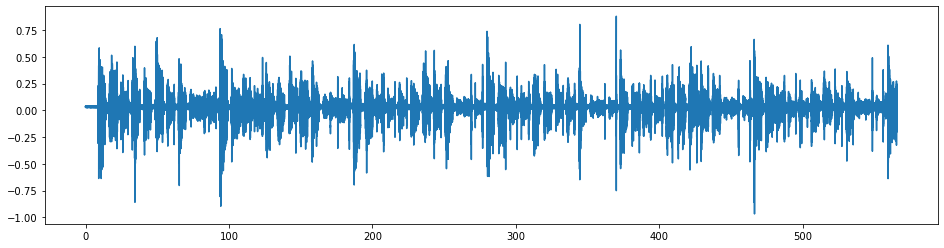

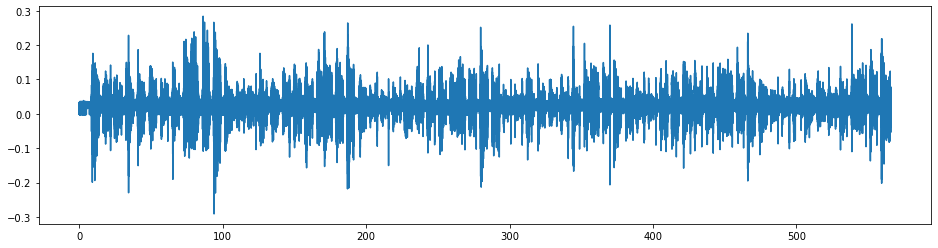

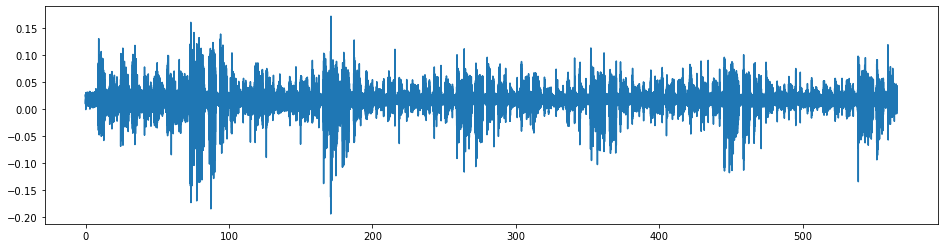

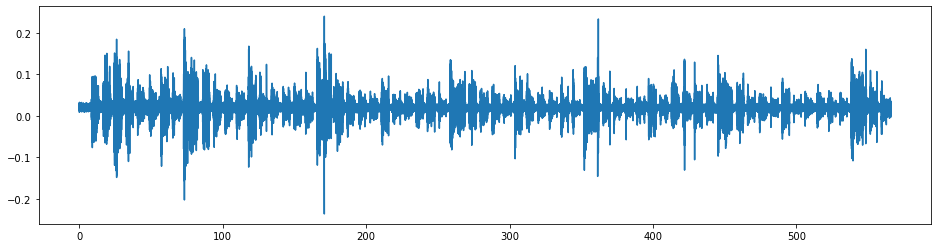

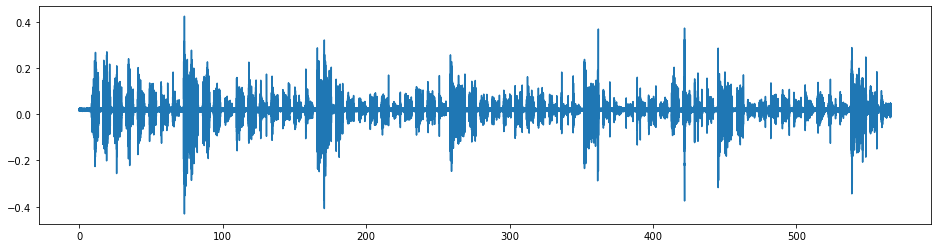

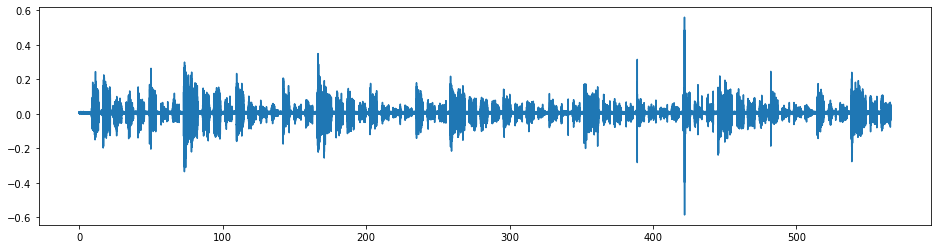

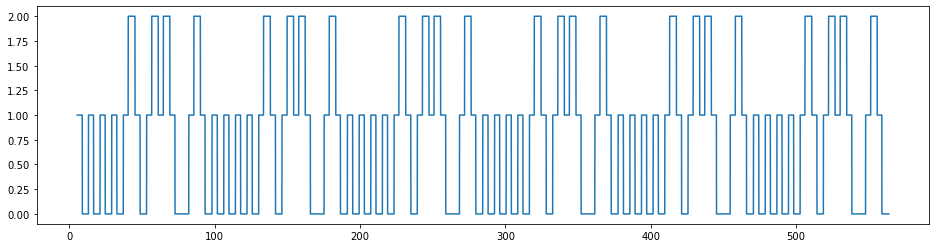

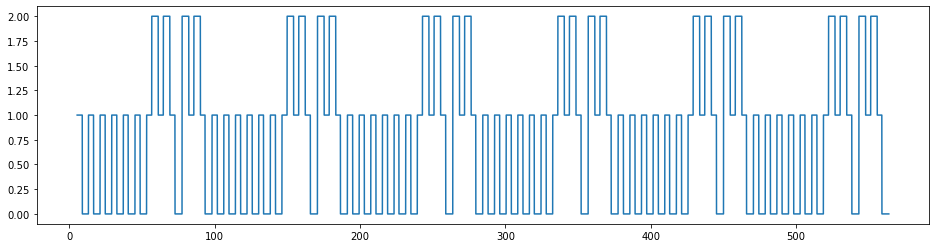

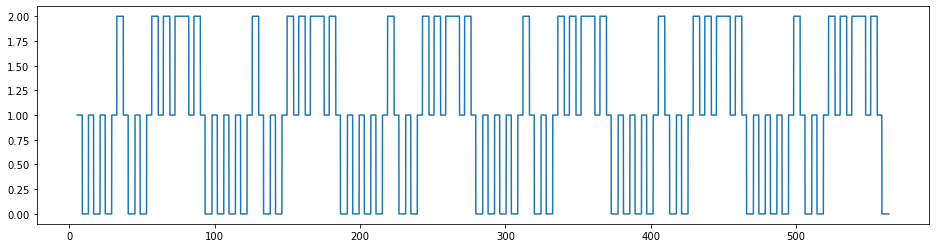

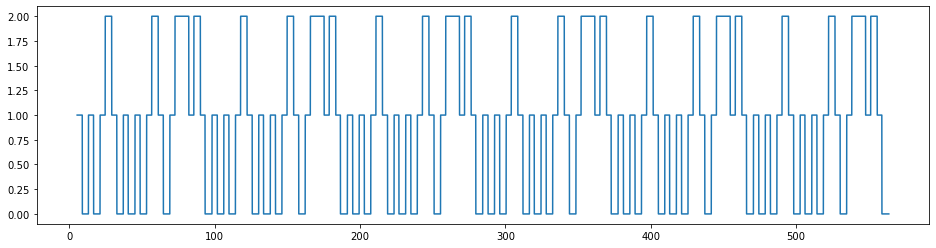

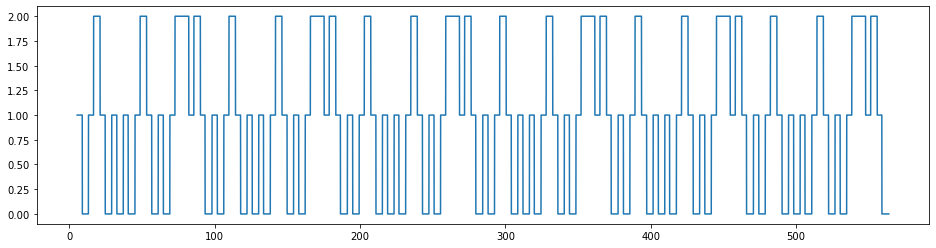

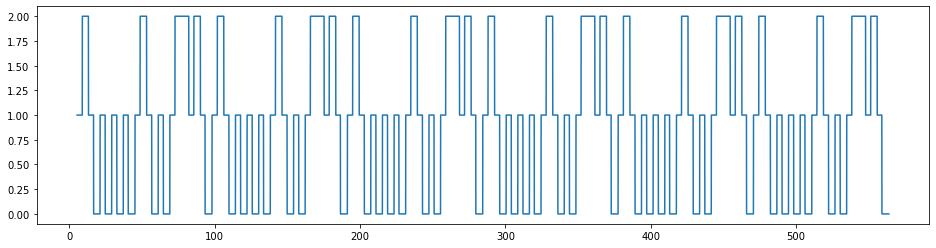

In [7]:
###########################################
##### Adapt to what you want to plot ######
###########################################
for i in range(EMG.shape[1]):
    plt.figure(figsize = (16,4))
    plt.plot(EMG.iloc[:,i])
    plt.show()
    
for i in range(EMG.shape[1]):
    plt.figure(figsize = (16,4))
    plt.plot(Targets.iloc[:,i])
    plt.show()

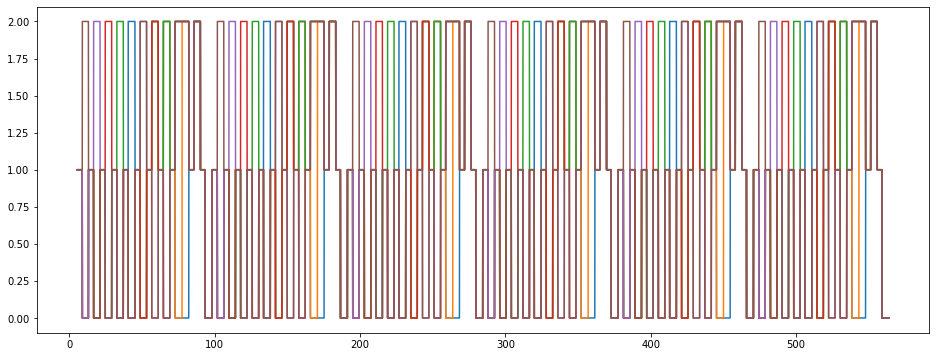

In [8]:
#All targets at once, we can see 6 repetitions in total
plt.figure(figsize = (16,6))
plt.plot(Targets)
plt.show()

In [9]:
#print all the combinations of fingers
Targets.groupby(list(Targets.columns)).size().reset_index().rename(columns={0:'count'})

,Right_Hand_channel1,Right_Hand_channel2,Right_Hand_channel3,Right_Hand_channel4,Right_Hand_channel5,Right_Hand_channel6,count
0,0,0,0,0,0,0,1724
1,0,0,0,0,0,2,1595
2,0,0,0,0,2,0,1609
3,0,0,0,0,2,2,1608
4,0,0,0,2,0,0,1608
5,0,0,2,0,0,0,1609
6,0,0,2,2,2,2,1758
7,0,2,2,2,2,2,1654
8,1,1,1,1,1,1,13825
9,2,0,0,0,0,0,1686


### Interpolate Targets
Align EMG and Targets (interpolate Targets to obtain same sampling frequency)

In [10]:
EMG, Targets = align(EMG,Targets)

### Cut the dataset

We will cut data into Training, Validation and Testing sets and extract windows. Since there are 6 repetition on each movement we will keep the last repetition for testing and the one before (5th repetition) for the validation set.

#### Q1: Why do we cut the dataset before extracting the windows ? Why three sets ?



In [11]:
def cut_datasets(EMG, Targets,val_cut, test_cut):

    """
    This function is defined to cut the data in three sets
    :param EMG: pandas DataFrame containing the data
    :param Targets: pandas DataFrame containing the targets
    :param val_cut: information on how/where to cut the dataset to obtain the validation set
    :param test_cut: information on how/where to cut the dataset to obtain the test set
    :return: 6 pandas DataFrames (or numpy arrays) containing EMG and targets of each sets
    """
    
    ###########################################
    ################## TODO ###################
    ###########################################
    

    EMG_train = EMG.iloc[:val_cut,]
    EMG_val = EMG.iloc[val_cut:test_cut,]
    EMG_test = EMG.iloc[test_cut:,]

    Targets_train = Targets.iloc[:val_cut,]
    Targets_val = Targets.iloc[val_cut:test_cut,]
    Targets_test = Targets.iloc[test_cut:,]

    return EMG_train, EMG_val, EMG_test, Targets_train, Targets_val, Targets_test

In [12]:
#Cut dataset
val_cut = int(len(EMG.index)/6)*4 # 5th block -> from 4/6 to 5/6
test_cut = int(len(EMG.index)/6)*5 # 6th block -> from 5/6 to end


EMG_train, EMG_val, EMG_test, Targets_train, Targets_val, Targets_test = cut_datasets(EMG, Targets,val_cut, test_cut)

### Sliding Window

Now, you have to perform an overlapping sliding window with windows of 200ms and a step of 50ms (150ms overlap)

In [13]:
def extract_time_windows(EMG,Targets, fs,win_len,step):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: pandas DataFrame (or numpy array) containing the data
    :param Targets: pandas DataFrame (or numpy array) containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)
    :return: A list of pandas Dataframes (or numpy arrays) containing the windows
    :return: A pandas DataFrame (or numpy array) containing the targets aligned for each window
    :note: The length of both outputs should be the same
    """
 
    ###########################################
    ################## TODO ###################
    ###########################################

    l_EMG = len(EMG.index)
    one_window = int(win_len*fs) # = 0.2sec*2000Hz = 400 rows
    one_step = int(step*fs) # = 0.05*2000Hz = 100 rows
    n_steps = int(l_EMG/one_step-(one_window/one_step-1))

    time_windows = []
    Targets_window = pd.DataFrame({'label' : pd.Series(dtype = 'int')})
    labels = Targets.groupby(list(Targets.columns)).size().reset_index().rename(columns={0:'count'})

    for s in range(n_steps):
        
        time_windows.append(EMG.iloc[s*one_step:s*one_step+one_window,:])
        t = Targets.iloc[s*one_step+one_window,:]

        label = labels.index[(labels['Right_Hand_channel1'] == t[0]) & (labels['Right_Hand_channel2'] == t[1]) &
                             (labels['Right_Hand_channel3'] == t[2]) & (labels['Right_Hand_channel4'] == t[3]) &
                             (labels['Right_Hand_channel5'] == t[4]) & (labels['Right_Hand_channel6'] == t[5])].tolist()[0]

        Targets_window.loc[len(Targets_window.index)] = label

    
    return time_windows, Targets_window

In [14]:
#Extract sliding windows
win_len = window_length      # = 0.2  #200 ms
step = sliding_step          # = 0.05 #50 ms
fs = sampling_frequency_EMG  # = 2000 #Hz

EMG_train_list, Targets_train_df = extract_time_windows(EMG_train, Targets_train, fs, win_len, step)
EMG_val_list, Targets_val_df = extract_time_windows(EMG_val, Targets_val, fs, win_len, step)
EMG_test_list, Targets_test_df = extract_time_windows(EMG_test, Targets_test, fs, win_len, step)

### Feature Extraction

Now you will have to extract meaningful information from each EMG channel to be able to decode user intention.

#### Q2: Why did you choose this set of features ?

In [15]:
def extract_features(windows, column_names,feat_names):
    """
    This function extracts features from raw EMG data. 
    The output matrix containing the features is called X (N_windows*N_features)
    Each feature you decide to extract should be extracted for each EMG channel of each window
    :param windows: List of pandas DataFrames (or numpy arrays) containing the windows
    :return: The matrix X
    """
    
    ###########################################
    ################## TODO ###################
    ###########################################

    X = pd.DataFrame(columns = column_names)
    
    for i, window in enumerate(windows):
        features = []
        rectified_window = window.abs() #absolute value of the EMG
        diff_window = window.diff()
        
        # Integral of absolute value (IAV) paper 1
        if 'IAV' in feat_names:
            IAV = rectified_window.sum().values.tolist()
            features.extend(IAV) #= pd.concat([features,IAV], axis = 0)

        # Mean absolute value paper 2
        if 'MAV' in feat_names:
            MAV = rectified_window.mean().values.tolist()
            features.extend(MAV) #= pd.concat([features,MAV], axis = 0)
        
        # Variance paper 1       
        if 'VAR' in feat_names:
            VAR = window.var().values.tolist()
            features.extend(VAR)

        # STD paper 3
        if 'STD' in feat_names:
            STD = window.std().values.tolist()
            #features = pd.concat([features,STD], axis = 0)
            features.extend(STD)

        # Mean of amplitude (MA): mean of the diff between two consecutive rows paper 1
        if 'MA' in feat_names:
            MA = diff_window.mean().values.tolist()
            #features = pd.concat([features,MA], axis = 0)
            features.extend(MA)

        # Difference absolute mean value, paper 3
        if 'DAMV' in feat_names:
            #features = pd.concat([features,DAMV], axis = 0)
            DAMV = diff_window.abs().mean().values.tolist()
            features.extend(DAMV)

        # Wavelength paper (length of the EMG) 1 & 2
        if 'WL' in feat_names:
            #features = pd.concat([features,WL], axis = 0)
            WL = diff_window.abs().sum().values.tolist()
            features.extend(WL)

        # root mean square (RMS) paper 2
        if 'RMS' in feat_names:
            #features = pd.concat([features,RMS], axis = 0)
            RMS = np.sqrt(window.pow(2).mean()).values.tolist()
            features.extend(RMS)
 
        # Wilson amplitude (WAMP) -> threshold fixed to 50 uV (paper 1)
        if 'WAMP' in feat_names:
            #features = pd.concat([features,WAMP], axis = 0)
            thresh = 50*10e-6
            WAMP = (diff_window.abs() > thresh).sum(axis=0).values.tolist()
            features.extend(WAMP)

        # Zero crossing (ZC). paper 1 & 2
        if 'ZC' in feat_names:
            #ZC = pd.Series(np.sum(((np.diff(np.sign(window), axis = 0)).astype(bool)),axis=0)).values.tolist()
            ZC = pd.Series(np.sum(((np.diff(np.sign(window.sub(window.mean())), axis = 0)).astype(bool)),axis=0)).values.tolist()
            #test_scores.sub(test_scores.mean())
            features.extend(ZC)

        # Maximum fractal length (MFL) paper 3
        if 'MFL' in feat_names:
            MFL = np.log10(diff_window.pow(2).sum().pow(1./2)).values.tolist()
            features.extend(MFL)
        
        # AUTOREGRESSIVE COEFF
        if 'AR' in feat_names:
            AR = []
            for j in range(6):
                res = AutoReg(window.iloc[:,j], 4, old_names=False).fit()
                AR.extend(res.params)
            features.extend(AR)
        
        ### FREQUENCY DOMAIN ###
        fs = 2000
        freqPSD, windowPSD = signal.welch(window, fs, 'flattop', axis = 0, scaling='spectrum')
        windowPSD = pd.DataFrame(windowPSD, columns=['Labjack_channel1','Labjack_channel2','Labjack_channel3','Labjack_channel4','Labjack_channel5','Labjack_channel6'])
        
        # Peak frequency (PKF)
        if 'PKF' in feat_names:
            #features = pd.concat([features,PKF], axis = 0)
            PKF = pd.Series(freqPSD[windowPSD.idxmax()]).values.tolist()
            features.extend(PKF)

        # Median frequency
        if 'MDF' in feat_names:
            MDF = (0.5*windowPSD.sum()).values.tolist()
            features.extend(MDF)

        X.loc[len(X)] = features
    return X

In [16]:
#Exctract features from training and testing sets

column_names = ["IAV1","IAV2","IAV3","IAV4","IAV5","IAV6",
                "MAV1","MAV2","MAV3","MAV4","MAV5","MAV6",
                "VAR1","VAR2","VAR3","VAR4","VAR5","VAR6",
                "STD1","STD2","STD3","STD4","STD5","STD6",
                "MA1","MA2","MA3","MA4","MA5","MA6",
                "DAMV1","DAMV2","DAMV3","DAMV4","DAMV5","DAMV6",
                "WL1","WL2","WL3","WL4","WL5","WL6",
                "RMS1","RMS2","RMS3","RMS4","RMS5","RMS6",
                "WAMP1","WAMP2","WAMP3","WAMP4","WAMP5","WAMP6",
                "ZC1","ZC2","ZC3","ZC4","ZC5","ZC6",
                "MFL1","MFL2","MFL3","MFL4","MFL5","MFL6",
                "AR0_1","AR0_2","AR0_3","AR0_4","AR0_5","AR0_6",
                "AR1_1","AR1_2","AR1_3","AR1_4","AR1_5","AR1_6",
                "AR2_1","AR2_2","AR2_3","AR2_4","AR2_5","AR2_6",
                "AR3_1","AR3_2","AR3_3","AR3_4","AR3_5","AR3_6",
                "AR4_1","AR4_2","AR4_3","AR4_4","AR4_5","AR4_6",
                "PKF1","PKF2","PKF3","PKF4","PKF5","PKF6",
                "MDF1","MDF2","MDF3","MDF4","MDF5","MDF6"]

feat_names = ['IAV', 'MAV', 'VAR', 'STD', 'MA', 'DAMV', 'WL', 'RMS', 'WAMP', 'ZC', 'MFL','AR','PKF','MDF']

X_train = extract_features(EMG_train_list,column_names,feat_names)
X_val = extract_features(EMG_val_list,column_names,feat_names)
X_test = extract_features(EMG_test_list,column_names,feat_names)

### Feature Standardization

Usually the features are re-scaled either between two bounded values or standardized (e.g $\frac{(x-\mu)}{\sigma}$). We provide the code to perform this step. We extract the mean and standard deviation of each feature from the training set and re-scale the features of all the sets with these values.

#### Q3.1: Why are we doing this step?
#### Q3.2: Explain why it is performed like this and not on all features directly.
#### Q4: Do you see any limitation of this approach for real time use ?

In [17]:
Feature_scaler = StandardScaler().fit(X_train)
X_train.iloc[:,:] = Feature_scaler.transform(X_train.iloc[:,:])
X_val.iloc[:,:] = Feature_scaler.transform(X_val.iloc[:,:])
X_test.iloc[:,:] = Feature_scaler.transform(X_test.iloc[:,:])

To train the model, it is good practice to shuffle the training samples (windows) to improve the trainng of decoders trained with iterative process.

In [18]:
X_train_shuffle, Targets_train_shuffle = shuffle(X_train, Targets_train_df)

### Machine Learning

Train and compare different ML models. Select one best model

#### Q5: Justify your choices and how you chose the best model

In [19]:
#In order to test the k-nearest neighbors (KNN) algorithm, we first try a range of different number of neighbours to find the optimal one.
#This value will then be used for all datasets (see next section: feature selection).
#As shown below, we'll keep n = 32 as the number of neighbours for the KNN algorithm.

neighs = [1,2,4,8,16,32,64,128,256]
for i,neigh in enumerate(neighs):
    KNN = KNeighborsClassifier(n_neighbors=neigh)
    KNN.fit(X_train_shuffle, np.ravel(Targets_train_shuffle))
    y_pred_KNN = KNN.predict(X_val)
    acc_KNN = accuracy_score(y_true=np.ravel(Targets_val_df), y_pred=y_pred_KNN)
    print('Accuracy (n_neighbors = {0}): {1:.2f}%'.format(neigh,acc_KNN*100))

Accuracy (n_neighbors = 1): 58.94%
Accuracy (n_neighbors = 2): 60.72%
Accuracy (n_neighbors = 4): 62.88%
Accuracy (n_neighbors = 8): 63.95%
Accuracy (n_neighbors = 16): 64.98%
Accuracy (n_neighbors = 32): 66.81%
Accuracy (n_neighbors = 64): 66.00%
Accuracy (n_neighbors = 128): 65.25%
Accuracy (n_neighbors = 256): 63.58%


In [20]:
###########################################
################## TODO ###################
###########################################

# Comparison of several models of classification

def models_selection(X_train, Y_train, X_val, Y_val):

    Y_train = np.ravel(Y_train)
    Y_val = np.ravel(Y_val)

    KNN = KNeighborsClassifier(n_neighbors=32)
    RF = RandomForestClassifier(random_state=42)
    GNB = GaussianNB()
    DTC = DecisionTreeClassifier(random_state=42)
    LSVC = LinearSVC(random_state=42, multi_class='crammer_singer') #, tol=1e-5
    SVC_ = SVC(random_state=42)
    RC = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1])
    LDA = LinearDiscriminantAnalysis()

    KNN.fit(X_train, Y_train)
    RF.fit(X_train, Y_train)
    GNB.fit(X_train, Y_train)
    DTC.fit(X_train, Y_train)
    LSVC.fit(X_train, Y_train)
    SVC_.fit(X_train, Y_train)
    RC.fit(X_train, Y_train)
    LDA.fit(X_train, Y_train)

    y_pred_KNN = KNN.predict(X_val)
    y_pred_RF = RF.predict(X_val)
    y_pred_GNB = GNB.predict(X_val)
    y_pred_DTC = DTC.predict(X_val)
    y_pred_LSVC = LSVC.predict(X_val)
    y_pred_SVC = SVC_.predict(X_val)
    y_pred_RC = RC.predict(X_val)
    y_pred_LDA = LDA.predict(X_val)

    acc_KNN = accuracy_score(y_true=Y_val, y_pred=y_pred_KNN)
    acc_RF = accuracy_score(y_true=Y_val, y_pred=y_pred_RF)
    acc_GNB = accuracy_score(y_true=Y_val, y_pred=y_pred_GNB)
    acc_DTC = accuracy_score(y_true=Y_val, y_pred=y_pred_DTC)
    acc_LSVC = accuracy_score(y_true=Y_val, y_pred=y_pred_LSVC)
    acc_SVC = accuracy_score(y_true=Y_val, y_pred=y_pred_SVC)
    acc_RC = accuracy_score(y_true=Y_val, y_pred=y_pred_RC)
    acc_LDA = accuracy_score(y_true=Y_val, y_pred=y_pred_LDA)
    
    print('Acc KNeigh: {:.2f}%'.format(acc_KNN*100))
    print('Acc RandomF: {:.2f}%'.format(acc_RF*100))
    print('Acc GNB: {:.2f}%'.format(acc_GNB*100))
    print('Acc DTC: {:.2f}%'.format(acc_DTC*100))
    print('Acc LSVC: {:.2f}%'.format(acc_LSVC*100))
    print('Acc SVC: {:.2f}%'.format(acc_SVC*100))
    print('Acc RC: {:.2f}%'.format(acc_RC*100))
    print('Acc LDA: {:.2f}%'.format(acc_LDA*100))

In [21]:
models_selection(X_train_shuffle, Targets_train_shuffle, X_val, Targets_val_df)

Acc KNeigh: 66.81%
Acc RandomF: 73.71%
Acc GNB: 50.16%
Acc DTC: 61.58%
Acc LSVC: 76.67%
Acc SVC: 74.52%
Acc RC: 76.45%
Acc LDA: 77.21%


In [22]:
# We see that the best performance is given by two models: LDA and LSVC. We test different values of the "tolerance" hyperparameter 
# in order to find the best one for each model

def LSVC_tols(X_train, Y_train, X_val, Y_val):
    Y_train = np.ravel(Y_train)
    Y_val = np.ravel(Y_val)
    tols = [1e-4,1e-3,1e-2,1e-1]

    for i,tol in enumerate(tols):
        LSVC = LinearSVC(random_state=42, tol=tol, multi_class='crammer_singer')
        LSVC.fit(X_train, Y_train)
        y_pred_LSVC = LSVC.predict(X_val)
        acc_LSVC = accuracy_score(y_true=Y_val, y_pred=y_pred_LSVC)
        
        print('Accuracy (tol = {0}): {1:.2f}%'.format(tol,acc_LSVC*100))

In [23]:
LSVC_tols(X_train_shuffle, Targets_train_shuffle, X_val, Targets_val_df)

Accuracy (tol = 0.0001): 76.67%
Accuracy (tol = 0.001): 76.67%
Accuracy (tol = 0.01): 76.83%
Accuracy (tol = 0.1): 77.05%


In [24]:
def LDA_tols(X_train, Y_train, X_val, Y_val):
    Y_train = np.ravel(Y_train)
    Y_val = np.ravel(Y_val)
    tols = [1e-5,1e-4,1e-3]

    for i,tol in enumerate(tols):
        LDA = LinearDiscriminantAnalysis(tol = tol)
        LDA.fit(X_train, Y_train)
        y_pred_LDA = LDA.predict(X_val)
        acc_LDA = accuracy_score(y_true=Y_val, y_pred=y_pred_LDA)
        
        print('Accuracy (tol = {0}): {1:.2f}%'.format(tol,acc_LDA*100))

In [25]:
LDA_tols(X_train_shuffle, Targets_train_shuffle, X_val, Targets_val_df)

Accuracy (tol = 1e-05): 77.21%
Accuracy (tol = 0.0001): 77.21%
Accuracy (tol = 0.001): 76.94%


## Features selection

In [26]:
# Now that we chose the two best models, we can start the feature selection to find the best combination of features to 
# optimize the models performance

# The best 2 models (with the best tolerance for LSVC and LDA) :

def final_model(X_train, Y_train, X_val, Y_val):

    Y_train = np.ravel(Y_train)
    Y_val = np.ravel(Y_val)

    LSVC = LinearSVC(random_state=42,tol = 1e-1, multi_class='crammer_singer') #, tol=1e-5
    LDA = LinearDiscriminantAnalysis(tol = 1e-3)

    LSVC.fit(X_train, Y_train)
    LDA.fit(X_train, Y_train)

    y_pred_LSVC = LSVC.predict(X_val)
    y_pred_LDA = LDA.predict(X_val)

    acc_LSVC = accuracy_score(y_true=Y_val, y_pred=y_pred_LSVC)
    acc_LDA = accuracy_score(y_true=Y_val, y_pred=y_pred_LDA)

    print('Acc LSVC: {:.2f}%'.format(acc_LSVC*100))
    print('Acc LDA: {:.2f}%'.format(acc_LDA*100))


In [27]:
# First selection : no autoregressive coefficients.

column_names = ["IAV1","IAV2","IAV3","IAV4","IAV5","IAV6",
                "MAV1","MAV2","MAV3","MAV4","MAV5","MAV6",
                "VAR1","VAR2","VAR3","VAR4","VAR5","VAR6",
                "STD1","STD2","STD3","STD4","STD5","STD6",
                "MA1","MA2","MA3","MA4","MA5","MA6",
                "DAMV1","DAMV2","DAMV3","DAMV4","DAMV5","DAMV6",
                "WL1","WL2","WL3","WL4","WL5","WL6",
                "RMS1","RMS2","RMS3","RMS4","RMS5","RMS6",
                "WAMP1","WAMP2","WAMP3","WAMP4","WAMP5","WAMP6",
                "ZC1","ZC2","ZC3","ZC4","ZC5","ZC6",
                "MFL1","MFL2","MFL3","MFL4","MFL5","MFL6",
                "PKF1","PKF2","PKF3","PKF4","PKF5","PKF6",
                "MDF1","MDF2","MDF3","MDF4","MDF5","MDF6"]

feat_names = ['IAV', 'MAV', 'VAR', 'STD', 'MA', 'DAMV', 'WL', 'RMS', 'WAMP', 'ZC', 'MFL','PKF','MDF']

X_train1 = extract_features(EMG_train_list,column_names,feat_names)
X_val1 = extract_features(EMG_val_list,column_names,feat_names)
X_test1 = extract_features(EMG_test_list,column_names,feat_names)

Feature_scaler = StandardScaler().fit(X_train1)
X_train1.iloc[:,:] = Feature_scaler.transform(X_train1.iloc[:,:])
X_val1.iloc[:,:] = Feature_scaler.transform(X_val1.iloc[:,:])
X_test1.iloc[:,:] = Feature_scaler.transform(X_test1.iloc[:,:])

X_train_shuffle1, Targets_train_shuffle1 = shuffle(X_train1, Targets_train_df)

final_model(X_train_shuffle1, Targets_train_shuffle1, X_val1, Targets_val_df)

Acc LSVC: 78.02%
Acc LDA: 75.38%


In [29]:
# Second selection : no frequency-domain features (no PKF and MDF)

column_names = ["IAV1","IAV2","IAV3","IAV4","IAV5","IAV6",
                "MAV1","MAV2","MAV3","MAV4","MAV5","MAV6",
                "VAR1","VAR2","VAR3","VAR4","VAR5","VAR6",
                "STD1","STD2","STD3","STD4","STD5","STD6",
                "MA1","MA2","MA3","MA4","MA5","MA6",
                "DAMV1","DAMV2","DAMV3","DAMV4","DAMV5","DAMV6",
                "WL1","WL2","WL3","WL4","WL5","WL6",
                "RMS1","RMS2","RMS3","RMS4","RMS5","RMS6",
                "WAMP1","WAMP2","WAMP3","WAMP4","WAMP5","WAMP6",
                "ZC1","ZC2","ZC3","ZC4","ZC5","ZC6",
                "MFL1","MFL2","MFL3","MFL4","MFL5","MFL6",
                "AR0_1","AR0_2","AR0_3","AR0_4","AR0_5","AR0_6",
                "AR1_1","AR1_2","AR1_3","AR1_4","AR1_5","AR1_6",
                "AR2_1","AR2_2","AR2_3","AR2_4","AR2_5","AR2_6",
                "AR3_1","AR3_2","AR3_3","AR3_4","AR3_5","AR3_6",
                "AR4_1","AR4_2","AR4_3","AR4_4","AR4_5","AR4_6"]

feat_names = ['IAV', 'MAV', 'VAR', 'STD', 'MA', 'DAMV', 'WL', 'RMS', 'WAMP', 'ZC', 'MFL','AR']

X_train2 = extract_features(EMG_train_list,column_names,feat_names)
X_val2 = extract_features(EMG_val_list,column_names,feat_names)
X_test2 = extract_features(EMG_test_list,column_names,feat_names)

Feature_scaler = StandardScaler().fit(X_train2)
X_train2.iloc[:,:] = Feature_scaler.transform(X_train2.iloc[:,:])
X_val2.iloc[:,:] = Feature_scaler.transform(X_val2.iloc[:,:])
X_test2.iloc[:,:] = Feature_scaler.transform(X_test2.iloc[:,:])

X_train_shuffle2, Targets_train_shuffle2 = shuffle(X_train2, Targets_train_df)

final_model(X_train_shuffle2, Targets_train_shuffle2, X_val2, Targets_val_df)

Acc LSVC: 77.05%
Acc LDA: 76.78%


In [30]:
# Third selection : no frequency-domain features and no AR coefficients

column_names = ["IAV1","IAV2","IAV3","IAV4","IAV5","IAV6",
                "MAV1","MAV2","MAV3","MAV4","MAV5","MAV6",
                "VAR1","VAR2","VAR3","VAR4","VAR5","VAR6",
                "STD1","STD2","STD3","STD4","STD5","STD6",
                "MA1","MA2","MA3","MA4","MA5","MA6",
                "DAMV1","DAMV2","DAMV3","DAMV4","DAMV5","DAMV6",
                "WL1","WL2","WL3","WL4","WL5","WL6",
                "RMS1","RMS2","RMS3","RMS4","RMS5","RMS6",
                "WAMP1","WAMP2","WAMP3","WAMP4","WAMP5","WAMP6",
                "ZC1","ZC2","ZC3","ZC4","ZC5","ZC6",
                "MFL1","MFL2","MFL3","MFL4","MFL5","MFL6"]

feat_names = ['IAV', 'MAV', 'VAR', 'STD', 'MA', 'DAMV', 'WL', 'RMS', 'WAMP', 'ZC', 'MFL']

X_train3 = extract_features(EMG_train_list,column_names,feat_names)
X_val3 = extract_features(EMG_val_list,column_names,feat_names)
X_test3 = extract_features(EMG_test_list,column_names,feat_names)

Feature_scaler = StandardScaler().fit(X_train3)
X_train3.iloc[:,:] = Feature_scaler.transform(X_train3.iloc[:,:])
X_val3.iloc[:,:] = Feature_scaler.transform(X_val3.iloc[:,:])
X_test3.iloc[:,:] = Feature_scaler.transform(X_test3.iloc[:,:])

X_train_shuffle3, Targets_train_shuffle3 = shuffle(X_train3, Targets_train_df)

final_model(X_train_shuffle3, Targets_train_shuffle3, X_val3, Targets_val_df)

Acc LSVC: 77.37%
Acc LDA: 75.05%


In [31]:
# 4th selection : remove each feature one by one to try to improve the models performance
# As the code would take too much space, only the results are displayed here (and the code of the last attemp = MFL removal)

# no IAV
#Acc LSVC: 77.53%
#Acc LDA: 75.05%

# or no MAV
#Acc LSVC: 77.48%
#Acc LDA: 75.05%

# OR no VAR
#Acc LSVC: 77.69%
#Acc LDA: 75.27%

# OR no STD
#Acc LSVC: 77.48%
#Acc LDA: 74.52%

# OR no MA
#Acc LSVC: 77.59%
#Acc LDA: 74.89%

# OR no DAMV
#Acc LSVC: 77.42%
#Acc LDA: 75.05%

# OR no WL
#Acc LSVC: 77.37%
#Acc LDA: 75.05%

# OR no RMS
#Acc LSVC: 77.26%
#Acc LDA: 74.57%

# OR no WAMP
#Acc LSVC: 78.12%
#Acc LDA: 73.81%

# OR no ZC
#cc LSVC: 77.96%
#Acc LDA: 74.46%

# OR no MFL
#Acc LSVC: 77.42%
#Acc LDA: 74.30%

column_names = ["IAV1","IAV2","IAV3","IAV4","IAV5","IAV6",
                "MAV1","MAV2","MAV3","MAV4","MAV5","MAV6",
                "VAR1","VAR2","VAR3","VAR4","VAR5","VAR6",
                "STD1","STD2","STD3","STD4","STD5","STD6",
                "MA1","MA2","MA3","MA4","MA5","MA6",
                "DAMV1","DAMV2","DAMV3","DAMV4","DAMV5","DAMV6",
                "WL1","WL2","WL3","WL4","WL5","WL6",
                "RMS1","RMS2","RMS3","RMS4","RMS5","RMS6",
                "WAMP1","WAMP2","WAMP3","WAMP4","WAMP5","WAMP6",
                "ZC1","ZC2","ZC3","ZC4","ZC5","ZC6"]
                #"MFL1","MFL2","MFL3","MFL4","MFL5","MFL6"

feat_names = ['IAV','MAV', 'VAR', 'STD','MA','DAMV', 'WL', 'RMS','WAMP', 'ZC']

X_train4 = extract_features(EMG_train_list,column_names,feat_names)
X_val4 = extract_features(EMG_val_list,column_names,feat_names)
X_test4 = extract_features(EMG_test_list,column_names,feat_names)

Feature_scaler = StandardScaler().fit(X_train4)
X_train4.iloc[:,:] = Feature_scaler.transform(X_train4.iloc[:,:])
X_val4.iloc[:,:] = Feature_scaler.transform(X_val4.iloc[:,:])
X_test4.iloc[:,:] = Feature_scaler.transform(X_test4.iloc[:,:])

X_train_shuffle4, Targets_train_shuffle4 = shuffle(X_train4, Targets_train_df)

final_model(X_train_shuffle4, Targets_train_shuffle4, X_val4, Targets_val_df)

Acc LSVC: 77.42%
Acc LDA: 74.30%


In [32]:
def corr_selection(features, threshold_):
    corr_ = features.corr()
    
    columns = np.full((corr_.shape[0],), True, dtype=bool)
    for i in range(corr_.shape[0]):
        for j in range(i+1, corr_.shape[0]):
            if abs(corr_.iloc[i,j]) >= threshold_:
                # Additional condition to make sure to eliminatre only one of the two features
                if columns[j]:
                    columns[j] = False
    selected_columns = features.columns[columns]
    select_feat = features[selected_columns]

    return select_feat

Text(0.5, 1.0, 'Correlation matrix after removing correlated features')

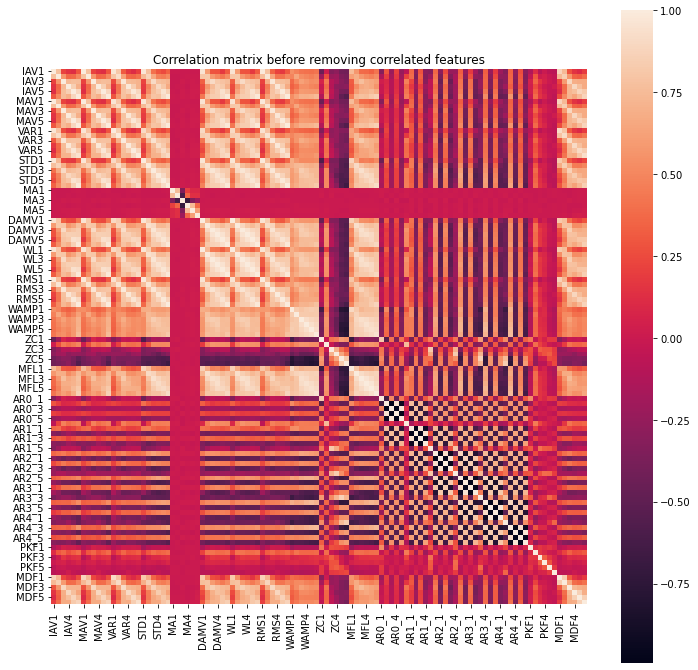

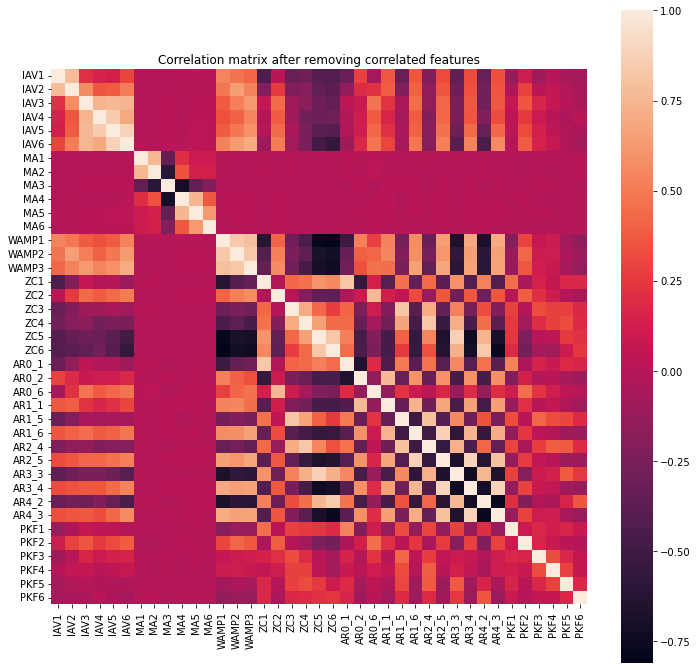

In [36]:
# 5th selection : remove correlated features
# Now we look at the correlation between features to remove the ones too correlated

uncorrelated_X_train = corr_selection(X_train_shuffle, 0.9)
corr_before = X_train_shuffle.corr()
corr_after = uncorrelated_X_train.corr()

plt.figure(figsize=(12,12)) 
ax = plt.axes()
sns.heatmap(corr_before, vmin=corr_before.values.min(), vmax=1, square=True)  
ax.set_title('Correlation matrix before removing correlated features')

plt.figure(figsize=(12,12)) 
ax = plt.axes()
sns.heatmap(corr_after, vmin=corr_after.values.min(), vmax=1, square=True)
ax.set_title('Correlation matrix after removing correlated features')


In [37]:
uncorrelated_X_val = X_val[uncorrelated_X_train.columns]

print("Before removing correlated features :")
final_model(X_train_shuffle, Targets_train_shuffle, X_val, Targets_val_df)

print("After removing correlated features :")
final_model(uncorrelated_X_train, Targets_train_shuffle, uncorrelated_X_val, Targets_val_df)

Before removing correlated features :
Acc LSVC: 77.05%
Acc LDA: 76.94%
After removing correlated features :
Acc LSVC: 70.10%
Acc LDA: 67.46%


In [38]:
# Wee see that removing correlated features decreases the models performance.

# 6th selection : run the model on the initial set of features using PCA_X_train to reduce the dimensionality and try 
# improving the performance

pca = PCA(n_components=2)
pca.fit(X_train_shuffle)
projected_train = pca.transform(X_train_shuffle)
PCA_X_train = pd.DataFrame(data = projected_train, columns = ['principal component 1', 'principal component 2'])

pca = PCA(n_components=2)
pca.fit(X_val)
projected_val = pca.transform(X_val)
PCA_X_val = pd.DataFrame(data = projected_val, columns = ['principal component 1', 'principal component 2'])

final_model(PCA_X_train, Targets_train_shuffle, PCA_X_val, Targets_val_df)

Acc LSVC: 41.22%
Acc LDA: 44.67%


### Train your final model

### Evaluate your best model (show performance and plot results obtained)

#### Q6: Comment your results and discuss the main advantages and limitations of your EMG decoding approach for prosthesis control.

In [39]:
###########################################
################## TODO ###################
###########################################

# final set of features :

final_column_names = ["IAV1","IAV2","IAV3","IAV4","IAV5","IAV6",
                "MAV1","MAV2","MAV3","MAV4","MAV5","MAV6",
                "VAR1","VAR2","VAR3","VAR4","VAR5","VAR6",
                "STD1","STD2","STD3","STD4","STD5","STD6",
                "MA1","MA2","MA3","MA4","MA5","MA6",
                "DAMV1","DAMV2","DAMV3","DAMV4","DAMV5","DAMV6",
                "WL1","WL2","WL3","WL4","WL5","WL6",
                "RMS1","RMS2","RMS3","RMS4","RMS5","RMS6",
                "ZC1","ZC2","ZC3","ZC4","ZC5","ZC6",
                "MFL1","MFL2","MFL3","MFL4","MFL5","MFL6",
                "PKF1","PKF2","PKF3","PKF4","PKF5","PKF6",
                "MDF1","MDF2","MDF3","MDF4","MDF5","MDF6"]

final_feat_names = ['IAV', 'MAV', 'VAR', 'STD', 'MA', 'DAMV', 'WL', 'RMS', 'ZC', 'MFL','PKF','MDF']

final_X_train = extract_features(EMG_train_list,column_names,feat_names)
final_X_val = extract_features(EMG_val_list,column_names,feat_names)
final_X_test = extract_features(EMG_test_list,column_names,feat_names)

Feature_scaler = StandardScaler().fit(final_X_train)
final_X_train.iloc[:,:] = Feature_scaler.transform(final_X_train.iloc[:,:])
final_X_val.iloc[:,:] = Feature_scaler.transform(final_X_val.iloc[:,:])
final_X_test.iloc[:,:] = Feature_scaler.transform(final_X_test.iloc[:,:])

final_X_train_shuffle, final_Targets_train_shuffle = shuffle(final_X_train, Targets_train_df)

Final accuracy on the testing dataset: 77.16%
Confusion matrix


<AxesSubplot:>

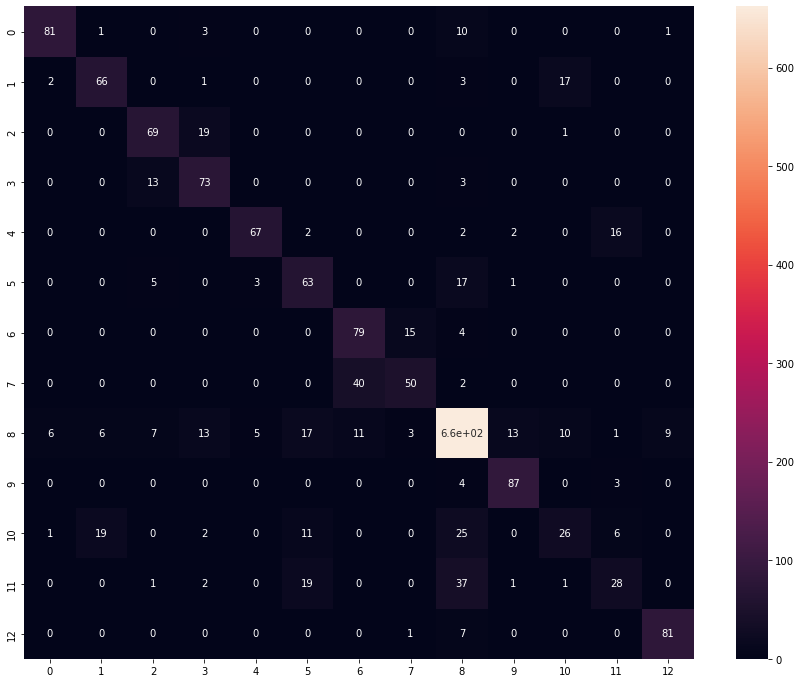

In [40]:
# For the final model, the LSVC classifier showed better results than LDA, so we are only going to keep this one
# We also look at the confusion matrix to visualise which hand positions have been misidentified 

best_X_train = final_X_train_shuffle
best_Y_train = np.ravel(final_Targets_train_shuffle)
best_X_test = final_X_test
best_Y_test = np.ravel(Targets_test_df)

LSVC = LinearSVC(random_state=42,tol = 1e-1, multi_class='crammer_singer')
LSVC.fit(best_X_train, best_Y_train)
y_pred_LSVC = LSVC.predict(best_X_test)
final_acc = accuracy_score(y_true=best_Y_test, y_pred=y_pred_LSVC)
print('Final accuracy on the testing dataset: {:.2f}%'.format(final_acc*100))

print("Confusion matrix")
cf_matrix = confusion_matrix(best_Y_test, y_pred_LSVC)
plt.figure(figsize = (15,12))
sns.heatmap(cf_matrix, annot=True)

In [43]:
# We can also run a PCA in order to visualize the clusters behavior

def PCA_analysis(X_train, Y_train, colors):
    
    pca = PCA().fit(X_train)
    ratio = pca.explained_variance_ratio_
    print('The 2D PCA contains {:.2%} of the information'.format(ratio[0]+ratio[1]))

    ########### 2D PCA ###########
    PCA_2d = PCA(n_components=2)
    PCs_2 = PCA_2d.fit_transform(X_train)
    PCA_df = pd.DataFrame(data = PCs_2, columns = ['Principal component 1', 'Principal component 2'])

    plt.figure(figsize=(10,10))
    plt.xlabel('Principal Component 1 ({:.2%})'.format(ratio[0]) ,fontsize = 15)  
    plt.ylabel('Principal Component 2 ({:.2%})'.format(ratio[1]),fontsize = 15)  
    plt.title("PCA with 2 Components",fontsize = 20) 
    plt.scatter(PCA_df.loc[:,'Principal component 1'], PCA_df.loc[:,'Principal component 2'], c = Y_train['label'], s = 10, cmap = colors)
    plt.grid()
    plt.show()

2D PCA before feature selection
The 2D PCA contains 57.24% of the information


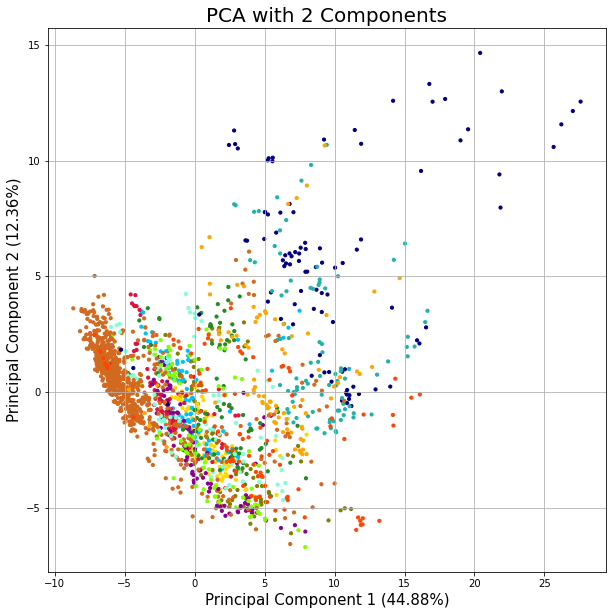

2D PCA after feature selection
The 2D PCA contains 70.08% of the information


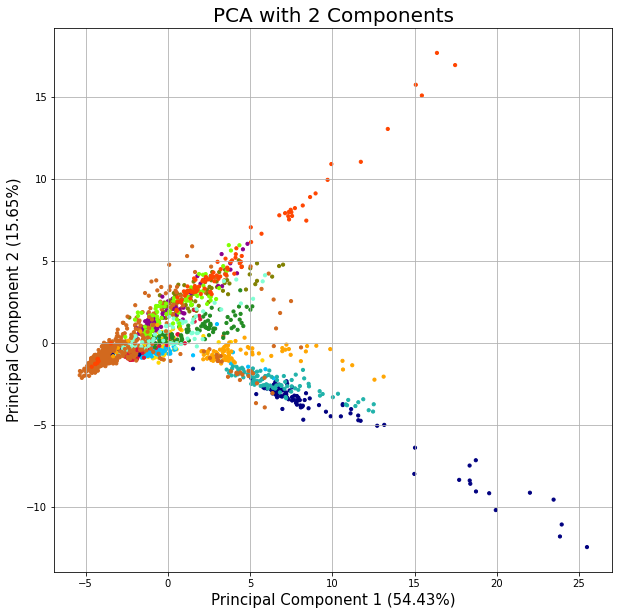

In [44]:
# Finally, we look at the explained variance of the first 2 components of the PCA, before and after selecting the features.
# As expected, we have a much higher explained variance and we can visually identify more easily the diffferent clusters on the 2D PCA plot 

c = ['orangered','olive','gold','forestgreen','deepskyblue','crimson','navy','lightseagreen','chocolate','darkmagenta','chartreuse','aquamarine','orange']
colors = ListedColormap(c)

print('2D PCA before feature selection')
PCA_analysis(X_test, Targets_test_df, colors)

print('2D PCA after feature selection')
PCA_analysis(best_X_test, Targets_test_df, colors)

# Questions

#### Q1: Cut the dataset: Why do we cut the dataset before extracting the windows ? Why three sets ?

The issue of splitting our data after the extraction of the windows is the fact that an overlap exists : each window shares some data with the window before and after. Therefore, if we split the list of windows, there will be shared data between the training and the validation datasets, and shared data between the validation and testing datasets.
Even though it represents very small data, it is preferable to split the datasets before, such that the datasets are independent and won’t share common data.

The goal of having three datasets is to train the models on one dataset (=training) and afterwards to select the model using another dataset (=validation).
Once the model has been selected and optimised, we can test this final model using an unused dataset (=testing). The concept addressed here is data leakage

#### Q2: Feature Extraction: Why did you choose this set of features ?

The goal of the feature extraction is to characterise the different signals in order to compare them more easily (with only one value per feature). Here, we select the features based on the literature already present about the analysis of EMG signals:
1. https://iopscience.iop.org/article/10.1088/0967-3334/24/2/307/pdf
3. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6946760/#CR6
4. https://www.sciencedirect.com/science/article/pii/S0957417412001200

There are several types of features: the time-domain features, which can be directly extracted from pre-processed EMG signals ; the frequency-domain features which are properties of the power spectral density of the signals; or also time-frequency and entropy-based features which we will not consider in this study. 

#### Q3.1: Why are we doing this step?
#### Q3.2: Explain why it is performed like this and not on all features directly.
#### Q4: Feature Standardization: Do you see any limitation of this approach for real time use ?

 Q3.1: The aim is to trivially put the variables on an identical scale so that they can be compared and processed. Indeed, some have much higher or smaller values, which complicates the performance of some classification models that perform, for example, distance calculations.

 Q3.2: Similar as in Q1, it is important not to normalise on all features directly because it could lead to data leakage. Indeed, we don’t want to train and validate our model with information coming from the testing set (since we would normalise using all features).
Therefore, we normalise only using the standardisation parameters from the training set, and we apply this to the validation and testing sets, thus avoiding data leakage. 

Q4: The main limitation of this approach is that it supposes low inter-individual (or even inter-measurements) variability. Indeed, if new data is standardised based on the normalization of our training dataset, there are risks that it is not adapted to the new data and that the standardisation is not optimal.

#### Q5: Machine Learning: Justify your choices and how you chose the best model

I tested multi class models since we need to classify each EMG window as one unique position. Therefore we are not dealing with multilabel classificaiton where several positions could be assigned to each EMG window.
I tested multiple supervised learning methods : 
- K-nearest neighbors classifier, 
- Random forest classifier
- Gaussian Naive Bayes
- Decision tree classifier
- Linear SVC (Support Vector Classification)
- SVC (Support Vector Classification)
- Ridge classifier
- Linear Discriminant Analysis

Two models showed better performance than the rest, LSVC and LDA. Therefore I chose them to do the feature selection.
I tried several different approaches:
- removing the AR coefficients : better accuracies
- removing the Frequency Domain (FD) features since the literature showed that they weren't always adapted to EMG signal classification: unexpectedly, lower accuracy. Thus, for this selection step, I removed only the AR coefficients. 
- remove correlated features with a threshold at 0.9 to avoid feature redudancy : worse accuracies
- finally, removing the remaining features individually to see if one of them lowers the accuracy: only the removal of the Wilson amplitude (WAMP) led to slightly better accuracies
- reduce the dimensionality of the intial whole set of features with a Principal Component Analysis (PCA) -> worse accuracies

Thanks to the model selection and the feature selection, we end up with:
- supervised algorithm: Linear Support Vector Classification (tol = 1e-1)
- final features: IAV, MAV, VAR, STD, MA, DAMV, WL, RMS, ZC, MFL
When testing this model configuration on the testing dataset, we obtain a good accuracy of 77.16%, meaning that we haven't overfit the model too much. Moreover, the explained variance of the 2D PCA is 70.08% which is quite satisfying and indicates that the features contain a high percentage of information and describe well the data. Finally, we also visually look at the 2D PCA plots before and after the feature selection: the clusters (labelled with colours) are much more distinguishable. 


#### Q6: General: Discuss the main advantages and limitations of your EMG decoding approach for prosthesis control.

 Advantages:
 - I tested many different algorithms, allowing a wide range of possibilities to be tested.
 - many different approaches were tested here for the feature selection: correlation-based, PCA-based, type-based (frequency etc).
 - the overall accuracy is quite good for a non-binary classificiation (more than 77%), meaning that the model is well fitted and found

 Limitations:
 - we only have the data of one person, one session: there is a risk of high variability inter-session and inter-individual, meaning that our feature selection and model selection might be good for this data, but not for other data. Indeed, the testing dataset comes from the same big dataset as the validation and training datasets (even though there aren't overlaps)
 - the optimization of the models could go further by tuning every hyoerparameter (not only the tolerance)
 - the entropy-based features haven't been tried and could increase the performance of the models. Moreover, there are other kind of features that could yield interesting results, such as looking at the envelope
 - as far as I know, no filtering steps were done here.
 - it might be hard to identify 13 different positions as it is a very high number of different labels. Maybe combining several positions together could improve the models performance.